In [1]:
%matplotlib inline

# Common imports

In [2]:
from Bio import SeqIO
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import statsmodels.stats

from scipy import stats
from collections import Counter


import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
results_dir = '../Results/{}_{:02}'.format(year, month)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Parameters to make pretty-ish plots

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

# Some mapping parameters

The `mapping_offset` came from the `meta_gene_analysis.ipynb` notebook, and was determined so that with the current offset the peak of the initiation reads map directly onto the start codon. The `utr_length_to_include` is not directly related to this analysis but it just in here because I'm recycling code from the `meta_gene_analysis.ipynb`. Can be set to whatever, and is ignored in the final calculations

In [4]:
mapping_offset = -16
utr_length_to_include = 50

# Read in the genome sequence data

In [5]:
genome_file = '../Data/Genome_files/U00096.3.fasta'
genome_seq = list(SeqIO.parse(genome_file, 'fasta'))[0]
organism = 'Escherichia'

In [6]:
utr_sequence_dict = {}
full_sequence_dict = {}
strand_dict = {}
location_dict = {}
genbank_seq = list(SeqIO.parse('../Data/Genome_files/U00096.3.gb', 'genbank'))[0]
for feature in genbank_seq.features:
    ###Only looking at CDSs and those not tagged as pseudogenes
    if feature.type != 'CDS':
        continue
    elif 'pseudo' in feature.qualifiers:
        continue
        
    ###
    name = feature.qualifiers['locus_tag'][0] + '_' + feature.qualifiers['gene'][0]
    start = feature.location.start
    end = feature.location.end
    
    ###Get the sequence for positive strand genes
    if feature.strand == 1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include])
    ###Get the sequence for negative strand genes (which needs to be reverse complemented)
    elif feature.strand == -1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include].reverse_complement())
    
    ###Add to the dictionary
    full_sequence_dict[name] = seq
    
    ###Separately just grab the 5'UTR as its own dictionary because it may be helpful
    utr_seq = seq[:utr_length_to_include]
    utr_sequence_dict[name] = utr_seq
    
    ###Store strand and locations as their own dictionaries
    strand_dict[name] = feature.strand
    location_dict[name] = (start, end)

print(len(utr_sequence_dict.keys()))
print(len(full_sequence_dict.keys()))
print(len(strand_dict.keys()))
print(len(location_dict.keys()))

4240
4240
4240
4240


# Read in sample `.wig` files and load all the mapped read data
Since this analysis is all about "translation efficiency" I need the ribosome profiling and RNA-seq files. I'm using the `.wig` files which contain all the information about the whole number count of reads where the 3' most nucleotide of the alignment was incremented by 1 for each read. No normalization for depth, this occurs later

In [9]:
sample_files = [('WTrep1_ribo', '../Data/WIG_files/WTrep1.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep2_ribo', '../Data/WIG_files/WTrep2.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_ribo', '../Data/WIG_files/RIBOTrep1.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_ribo', '../Data/WIG_files/RIBOTrep2.ribo_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep1_rna', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_r.wig'),\
               ('WTrep2_rna', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_rna', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_rna', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_r.wig')]

sample_names = [i[0] for i in sample_files]

**This code maps the `.wig` file reads to their genes and adds in the proper offset**

In [10]:
feature_dict_meta = {}
for sample_file in sample_files[:]:
    sample_name, fwd, rev = sample_file
    print('##### {}'.format(sample_name))
    feature_dict_meta[sample_name] = {}
    ################################
    ###Essentially get the fwd and rev genome coverage
    fwd_dicty = {}
    rev_dicty = {}
    with open(fwd) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                fwd_dicty[int(split_line[0])+mapping_offset] = float(split_line[1])#Note: mapping offset addition
    print('Done with fwd')
    with open(rev) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                rev_dicty[int(split_line[0])-mapping_offset] = float(split_line[1])#Note: mapping offset subtraction
    print('Done with rev')

    for gene_name in full_sequence_dict.keys():        
        ####Dealing with positive strand genes first
        if strand_dict[gene_name] == 1:
            ###Get all positions that I care about
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            ###Append read values and if there are none, append zero
            for i in range(pos[0], pos[1]+1):
                try:
                    sequencing.append(fwd_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing
        ####And repeat for negative strand genes
        elif strand_dict[gene_name] == -1:
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            for i in range(pos[0], pos[1]+1):
                try:
                    sequencing.append(rev_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing[::-1]###Note the CRUCIAL reverse here

##### WTrep1_ribo
Done with fwd
Done with rev
##### WTrep2_ribo
Done with fwd
Done with rev
##### RIBOTrep1_ribo
Done with fwd
Done with rev
##### RIBOTrep2_ribo
Done with fwd
Done with rev
##### WTrep1_rna
Done with fwd
Done with rev
##### WTrep2_rna
Done with fwd
Done with rev
##### RIBOTrep1_rna
Done with fwd
Done with rev
##### RIBOTrep2_rna
Done with fwd
Done with rev


# Show total read counts for each sample and store

**This is for RPKM normalization. For "total mapped reads" I will only consider total reads mapped to CDSs that I'm investigating. Note that this may double count some small number of partially overlapping genes but this should be inconsequential and I feel is far superior than considering all reads mapped including those mapped to intragenic regions, pseudogenes, etc.**

In [11]:
total_read_dict = {}
for i in sample_names:
    all_features = []
    for j in feature_dict_meta[i].values():
        all_features.extend(j[utr_length_to_include:-1*utr_length_to_include])
    print(i, np.sum(all_features))
    total_read_dict[i] = np.sum(all_features)

WTrep1_ribo 24372749.0
WTrep2_ribo 16785668.0
RIBOTrep1_ribo 13060357.0
RIBOTrep2_ribo 14826861.0
WTrep1_rna 4128448.0
WTrep2_rna 3909465.0
RIBOTrep1_rna 4244009.0
RIBOTrep2_rna 3061314.0


# Create datatable of RPKM counts for each sample

**Defining Translation Efficiency (TE) here as: `RPKM_ribo/RPKM_rna`**

**Also replacing any/all "infinite" values with NaN**

In [12]:
df_master = pd.DataFrame()
for sample in sample_names:
    print(sample)
    for gene in strand_dict.keys():
        gene_len = location_dict[gene][1]-location_dict[gene][0]
        ###Only calculating averages across the CDS (ignoring UTRs)
        reads = feature_dict_meta[sample][gene][utr_length_to_include:-1*utr_length_to_include]
        ###This is the formula for making these values RPKM
        df_master.set_value(gene, sample, (np.sum(reads)*10e9)/(total_read_dict[sample]*gene_len))

###Just dividing each replicate pair (ribo and rna) to create TE measurements        
for ribo_sample in sample_names[:4]:
    rna_sample = ribo_sample.replace('_ribo', '_rna')
    df_master[ribo_sample.replace('_ribo', '_TE')] = df_master[ribo_sample]/df_master[rna_sample]
    ###Remove infinite values, or rather call then NaN
    df_master[ribo_sample.replace('_ribo', '_TE')].replace(np.inf, np.nan, inplace=True)
    df_master[ribo_sample.replace('_ribo', '_TE')].replace(-np.inf, np.nan, inplace=True)

WTrep1_ribo
WTrep2_ribo
RIBOTrep1_ribo
RIBOTrep2_ribo
WTrep1_rna
WTrep2_rna
RIBOTrep1_rna
RIBOTrep2_rna


**Calculate condition averages for Translation Efficiency and log2 fold changes**

In [13]:
###Calculate averages and fold change
df_master['WT_avg_TE'] = df_master[['WTrep1_TE', 'WTrep2_TE']].mean(skipna=False, axis=1)
df_master['RIBOT_avg_TE'] = df_master[['RIBOTrep1_TE', 'RIBOTrep2_TE']].mean(skipna=False, axis=1)
###Fold changes
df_master['log2FC_TE'] = df_master['RIBOT_avg_TE'].apply(np.log2) - df_master['WT_avg_TE'].apply(np.log2)
###Remove the infinite values
df_master['log2FC_TE'].replace(np.inf, np.nan, inplace=True)
df_master['log2FC_TE'].replace(-np.inf, np.nan, inplace=True)
df_master.head()

,WTrep1_ribo,WTrep2_ribo,RIBOTrep1_ribo,RIBOTrep2_ribo,WTrep1_rna,WTrep2_rna,RIBOTrep1_rna,RIBOTrep2_rna,WTrep1_TE,WTrep2_TE,RIBOTrep1_TE,RIBOTrep2_TE,WT_avg_TE,RIBOT_avg_TE,log2FC_TE
b1387_paaZ,2.606953,4.076466,4.116537,2.307508,8.287157,30.004631,18.426297,31.931292,0.314577,0.135861,0.223406,0.072265,0.225219,0.147835,-0.607341
b0448_mdlA,94.647698,108.531338,121.350770,109.935990,351.105448,360.673259,381.414206,418.224282,0.269571,0.300913,0.318160,0.262864,0.285242,0.290512,0.026411
b3603_lldP,173.681343,166.924091,67.505238,57.833409,241.344159,253.318079,140.863529,142.024833,0.719642,0.658951,0.479224,0.407206,0.689296,0.443215,-0.637116
b2166_psuK,1.742226,2.529708,1.625639,2.147935,12.856782,35.300034,5.002681,34.676976,0.135510,0.071663,0.324954,0.061941,0.103587,0.193447,0.901103
b2513_yfgM,3263.854821,3498.690567,4017.024046,3931.585768,3920.014223,4419.679657,4090.259523,4371.208740,0.832613,0.791616,0.982095,0.899428,0.812115,0.940761,0.212145


**Assessing the statistical significance of differences in TE using independent t-tests for each gene**

Which is to say, for each gene I have 2 conditions and 2 samples in each condition so I am simply comparing: 

    [WT_rep1_TE, WT_rep2_TE] against [RIBOT_rep1_TE, RIBOT_rep2_TE]
    
And reporting the raw p-value from this (which will subsequently be adjusted for multiple testing). Worth noting here that I'm assuming equal variance in the T-test which may/may not be correct.

In [14]:
df_master['raw_ttest_pval'] = np.nan
for index in df_master.index:
    a = [df_master.loc[index]['WTrep1_TE'], df_master.loc[index]['WTrep2_TE']]
    b = [df_master.loc[index]['RIBOTrep1_TE'], df_master.loc[index]['RIBOTrep2_TE']]
    tval, pval = stats.ttest_ind(a, b, equal_var=True)
    df_master.set_value(index, 'raw_ttest_pval', pval)

**About that multiple testing... Here I'm converting each p-value into a FDR corrected p-value using the pretty standard "Benjamini-Hochberg" procedure**

In [15]:
tempy = df_master[df_master['raw_ttest_pval'].isnull()==False]
sigs, new_pvals, trash1, trash2 = statsmodels.stats.multitest.multipletests(list(tempy['raw_ttest_pval']),\
                                                                        alpha=0.05, method='fdr_bh')
tempy['fdr_corrected_pval_bh'] = new_pvals
df_master['fdr_corrected_pval_bh'] = np.nan
for index in tempy.index:
    df_master.set_value(index, 'fdr_corrected_pval_bh', tempy.loc[index]['fdr_corrected_pval_bh'])

/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


** A quick glance shows genes sorted for significance **

And another way to show why we don't see significance with multiple testing would be to use the Bonerroni correction where we would divide the p-value we care about (0.01) by 4,240 or some number close to that which is the number of hypotheses we're testing. By that criteria we need an un-adjusted p-value to be < ~10e-6 to be significant and we don't realy get close

In [16]:
df_master.sort_values('raw_ttest_pval', inplace=True)

In [17]:
df_master.head(n=20)

,WTrep1_ribo,WTrep2_ribo,RIBOTrep1_ribo,RIBOTrep2_ribo,WTrep1_rna,WTrep2_rna,RIBOTrep1_rna,RIBOTrep2_rna,WTrep1_TE,WTrep2_TE,RIBOTrep1_TE,RIBOTrep2_TE,WT_avg_TE,RIBOT_avg_TE,log2FC_TE,raw_ttest_pval,fdr_corrected_pval_bh
b0002_thrA,5736.790547,6069.211024,1404.516244,1248.406336,5714.781693,6067.081255,2303.646172,2050.393423,1.003851,1.000351,0.609693,0.608862,1.002101,0.609277,-0.717857,0.000021,0.086443
b1504_ydeS,12.362917,26.926388,24.513163,11.431383,27.369692,57.805531,13.312219,6.151735,0.451701,0.465810,1.841403,1.858237,0.458755,1.849820,2.011588,0.000062,0.093672
b4206_ytfB,436.619913,459.629010,509.252329,537.239218,705.058686,744.551524,693.235341,731.016705,0.619267,0.617323,0.734602,0.734921,0.618295,0.734761,0.248980,0.000072,0.093672
b2143_cdd,1555.873076,1584.617905,675.698127,644.729996,853.934391,864.192690,591.062502,568.420291,1.822005,1.833640,1.143192,1.134249,1.827822,1.138721,-0.682712,0.000113,0.093672
b2232_ubiG,2014.584739,2164.627375,1271.890319,1284.536434,914.613339,979.995637,876.673112,876.507335,2.202663,2.208813,1.450815,1.465517,2.205738,1.458166,-0.597107,0.000114,0.093672
b2020_hisD,67.596379,69.846121,70.993700,83.208204,92.805278,96.043558,106.528351,125.155983,0.728368,0.727234,0.666430,0.664836,0.727801,0.665633,-0.128817,0.000247,0.127354
b1919_dcyD,327.570323,348.876773,313.407340,394.284264,301.856922,318.764999,413.002475,516.296960,1.085184,1.094464,0.758851,0.763677,1.089824,0.761264,-0.517626,0.000253,0.127354
b3472_dcrB,6867.650118,7224.758731,5377.569305,5184.091176,3989.279761,4171.477102,7495.280015,7557.604583,1.721526,1.731943,0.717461,0.685944,1.726734,0.701702,-1.299115,0.000262,0.127354
b4390_nadR,359.714630,392.815702,422.270544,432.677380,726.861772,788.321172,705.158903,723.255413,0.494887,0.498294,0.598830,0.598236,0.496591,0.598533,0.269374,0.000288,0.127354
b3417_malP,2254.904808,2354.865272,86.034588,91.842614,1224.262101,1275.741993,108.266038,110.523084,1.841848,1.845879,0.794659,0.830981,1.843864,0.812820,-1.181724,0.000314,0.127354


In [18]:
df_master.to_csv('{}/TE_master_table.csv'.format(results_dir))

# Consistency summary of within condition correlations

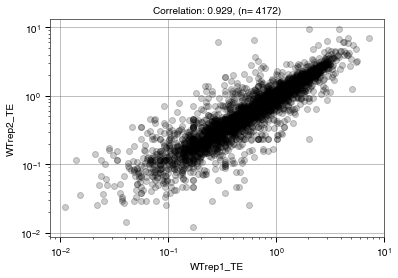

In [19]:
compare_x = 'WTrep1_TE'
compare_y = 'WTrep2_TE'
tempy = df_master[df_master[[compare_x, compare_y]].isnull().any(axis=1)==False]
rho, p = stats.spearmanr(tempy[compare_x], tempy[compare_y])
n = len(tempy.index)

fig, ax = plt.subplots()
ax.loglog(tempy[compare_x], tempy[compare_y], c='k', alpha=0.2, marker='o', linestyle='')
ax.set_xlabel(compare_x)
ax.set_ylabel(compare_y)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
plt.savefig('{}/WT_TE_comparison.pdf'.format(results_dir), bbox_inches='tight')

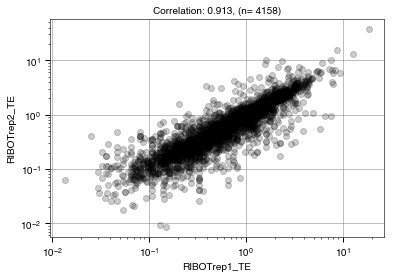

In [20]:
compare_x = 'RIBOTrep1_TE'
compare_y = 'RIBOTrep2_TE'
tempy = df_master[df_master[[compare_x, compare_y]].isnull().any(axis=1)==False]
rho, p = stats.spearmanr(tempy[compare_x], tempy[compare_y])
n = len(tempy.index)

fig, ax = plt.subplots()
ax.loglog(tempy[compare_x], tempy[compare_y], c='k', alpha=0.2, marker='o', linestyle='')
ax.set_xlabel(compare_x)
ax.set_ylabel(compare_y)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
plt.savefig('{}/RIBOT_TE_comparison.pdf'.format(results_dir), bbox_inches='tight')

# Comparing average values across conditions

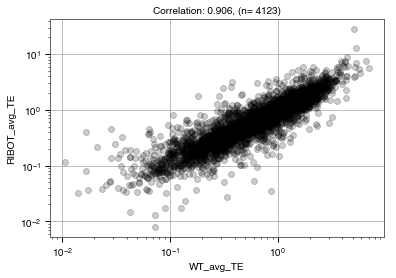

In [21]:
compare_x = 'WT_avg_TE'
compare_y = 'RIBOT_avg_TE'
tempy = df_master[df_master[[compare_x, compare_y]].isnull().any(axis=1)==False]
rho, p = stats.spearmanr(tempy[compare_x], tempy[compare_y])
n = len(tempy.index)

fig, ax = plt.subplots()
ax.loglog(tempy[compare_x], tempy[compare_y], c='k', alpha=0.2, marker='o', linestyle='')
ax.set_xlabel(compare_x)
ax.set_ylabel(compare_y)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
plt.savefig('{}/Condition_TE_comparison.pdf'.format(results_dir), bbox_inches='tight')